# Cognitive Extent: Processing and Inspection

## Housekeeping

In [1]:
import pandas as pd
import numpy as np
from functools import partial
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 1000

import string
import re

#import spacy as s
#import en_core_web_sm as en

#from pattern.en import pluralize, singularize
from itertools import compress
 
import time
import swifter
#from pandarallel import pandarallel
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from multiprocessing import Pool, cpu_count

In [3]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [4]:
wn_lemma = WordNetLemmatizer()

In [5]:
get_lemma = wn_lemma.lemmatize #speeds up the dot accessor lookup

In [39]:
%timeit wn_lemma.lemmatize('refrigerators')

The slowest run took 6.39 times longer than the fastest. This could mean that an intermediate result is being cached.
9.01 µs ± 9.08 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%timeit get_lemma('refrigerators')

4.7 µs ± 42.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [6]:
lemmas_cache = {}
lemmacache_get = lemmas_cache.get
def lemma_cache(word):
    if word=='|':
        return word
    elif '|' in word:
        return "|".join([lemma_cache(z) for z in word.split("|")])
    else:
        a = lemmacache_get(word)
        if a:
            return a
        else:
            lemma = get_lemma(word)
            lemmas_cache[word] = lemma
            return lemma

In [7]:
stopwords_cache = {}
stopwordscache_get = stopwords_cache.get
STOPWORDS = set(stopwords.words('english'))
def stopword_cache(word):
    if word=='|':
        return word
    elif '|' in word:
        return '|'.join([stopword_cache(z) for z in word.split("|")])
    else:
        a = stopwordscache_get(word)                              
        if a:
            return a
        else:
            if word in STOPWORDS:
                result = "|"
            else:
                result = word
            stopwords_cache[word] = result
            return result

In [8]:
#warm up the stopwords cache:
zz = [stopword_cache(cc) for cc in STOPWORDS]

In [9]:
def applyParallel(dfGrouped, func):
    "For applying after a groupby"
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pandas.concat(ret_list)

In [10]:
#from pywsd.utils import lemmatize_sentence

In [11]:
#nlp = en.load()
#nlp = en.load(disable=['ner','entity_ruler'])

# Preprocessing

In [14]:
df = pd.read_csv("./data_processNEW.csv",engine='c')

In [15]:
df.head()

,pmid,year,title,number_authors
0,12255545,1946,The nutrition of expectant and nursing mothers in relation to maternal and infant mortality and morbidity.,1
1,12278355,1946,Ritual mutilation among primitive peoples.,1
2,12305597,1946,Vitamin-C test for ovulation.,1
3,12332284,1946,The clinical use of oral basal temperatures.,1
4,16016713,1946,The Army Medical Library: In Retrospect and Future.,1


## Preprocessing

In [16]:
"""Before phrases can be extracted from them, the titles were processed in the following way: Periods, colons, semicolons, dashes, and commas were replaced with a code specifying phrase separation. All punctuation symbols were removed, except for ampersands, which were replaced with “and.” Leading and trailing spaces were removed, and multiple spaces were replaced with a single space. Cases were ignored. Numbers and single letters were removed. Singular and plural forms of nouns were collated.""".split('.')

['Before phrases can be extracted from them, the titles were processed in the following way: Periods, colons, semicolons, dashes, and commas were replaced with a code specifying phrase separation',
 ' All punctuation symbols were removed, except for ampersands, which were replaced with “and',
 '” Leading and trailing spaces were removed, and multiple spaces were replaced with a single space',
 ' Cases were ignored',
 ' Numbers and single letters were removed',
 ' Singular and plural forms of nouns were collated',
 '']

In [17]:
df['workingtitle'] = df['title'].str.lower()

In [18]:
# strip leading or trailing brackets. trailing brackets occur when data is "Not Available"
df['workingtitle'] = df['workingtitle'].str.strip('[].')

In [19]:
df = df.replace('Not Available',np.nan)

In [20]:
len(df)

15834578

In [21]:
df = df[pd.notnull(df['title'])]

In [22]:
len(df)

15834302

In [23]:
#number of missing titles:
14243892-14243608

284

In [24]:
df = df.drop_duplicates()

In [25]:
len(df)

15834302

In [26]:
df.tail()

,pmid,year,title,number_authors,workingtitle
15834573,29334060,2012,Nonspecific Bacterial Flora Isolated from the Body Surface and Inside Ixodes ricinus Ticks.,5,nonspecific bacterial flora isolated from the body surface and inside ixodes ricinus ticks
15834574,29334063,2012,Penicillin Resistance in Enterococcus faecalis: Molecular Determinants and Epidemiology.,3,penicillin resistance in enterococcus faecalis: molecular determinants and epidemiology
15834575,29334066,2012,"Comparative Study of Microcalorimetric Behavior of Escherichia coli, Proteus mirabilis and Klebsiella pneumoniae.",4,"comparative study of microcalorimetric behavior of escherichia coli, proteus mirabilis and klebsiella pneumoniae"
15834576,29334069,2012,Quantitative Estimation of Porcine Endogenous Retrovirus Release from PK15 Cells.,6,quantitative estimation of porcine endogenous retrovirus release from pk15 cells
15834577,29334070,2012,Ethanol Production Potential of Ethanol-Tolerant Saccharomyces and Non-Saccharomyces Yeasts.,4,ethanol production potential of ethanol-tolerant saccharomyces and non-saccharomyces yeasts


In [27]:
#inspecting a random title:
df.iloc[16602]

pmid                      20297066
year                          1946
title             [Not Available].
number_authors                   1
workingtitle         not available
Name: 16602, dtype: object

In [28]:
#turn ampersands to ands, strip extraneous spaces
df['title'] = df['title'].str.replace('&','and')
df['title'] = df['title'].str.strip(' ').replace('  ',' ').replace('   ',' ')

In [29]:
df.iloc[7687]

pmid                                                                                                    20275948
year                                                                                                        1946
title             Regional enteritis; a report of a case complicating pregnancy with a review of the literature.
number_authors                                                                                                 2
workingtitle       regional enteritis; a report of a case complicating pregnancy with a review of the literature
Name: 7687, dtype: object

In [33]:
def regex_I(string,debug=False):
    """Deprecated in favor of pandas string methods"""
    """inserts phrase seperations symbols. here we use the pipe (|) delimiter."""
    
    #Note that removing periods means d.d.t. becomes d d t, which is then removed.
    #we skip removing periods for this reason.
    
    #We also replicate the paper's choice to remove commas, even though a list that uses semicolons will do so in order
    #to incorporate commas into the list elements. I.E. "Injuries of the head, Bilateral" is one concept.
    #Also, "2,3dimethyl-ether" is one concept, not two.
    
    #Also, the paper underspecifies how edgecases are handled when "numbers are removed." 
    #We interpret this not to mean "all numeric digits" but instead "continuous strings of 
    #latin numerals surrounded by spaces." I.e. "144 cases of the flu." Consider that:
    #   "Type II diabetes" would turn into "type diabetes" if all roman numerals were removed.
    #   "N-2305" is part of a chemical name, we choose to keep those numbers.
    
    #Below, we remove year ranges (1965-1984), and single digits
    
    #The paper removes single letters. We replicate this, noting that "e. coli" will turn into "coli"
    
    #If the noun "e. coli" is always referred to in abbreviated form, this won't double count the concept.
    
    #There's an edge case of two repeated single letters -- a a
    
    #We also assume that year ranges are marked with a dash and not a hyphen
    
    #Note: pandas.str.replace accepts regexes, which means this code could be refactored + cleaned up, for a performance
    #increase
    #--------------------------------------------------------
    
    x = ' '.join([w for w in string.split() if len(w)>1])#get rid of single letters and single digits
    if debug:
        print(x)
    x = re.sub("\s*[,;:–—]\s*", "|",x) #Replace the specified punctuation with a phrase seperation symbol
    if debug:
        print(x)
    x = x.replace("(","").replace(")","") #paper strips out parentheses as part of "all punctuation is removed"
    if debug:
        print(x)
    #get rid of number ranges e.g. 1940-1965 (or 4-22), and other repeated digits surrounded by spaces
    x = re.sub(r"(\d+-\d+|^\d+\s|\s\d+\s|\s\d+$)"," ",x)
    if debug:
        print(x)
    x = x.replace('  ',' ').strip()
    return x

In [35]:
df['workingtitle'] = df['workingtitle'].str.replace(r"\s*[,;:–—]\s*", "|") #remove punctuation

In [39]:
df['workingtitle'] = df['workingtitle'].str.replace(r"\s[a-z]\s"," ") #remove single letters

In [44]:
df['workingtitle']=df['workingtitle'].str.replace(r"(\d+-\d+|^\d+\s|\s\d+\s|\s\d+$)","")#get rid of digit ranges, and digits

In [123]:
#df.to_csv("Title_has_been_through_first_regex.csv",index=False)

In [26]:
#df = pd.read_csv("Title_has_been_through_first_regex.csv",engine='c',usecols=[0,2,3])

In [45]:
df.head()

,pmid,year,title,number_authors,workingtitle
0,12255545,1946,The nutrition of expectant and nursing mothers in relation to maternal and infant mortality and morbidity.,1,the nutrition of expectant and nursing mothers in relation to maternal and infant mortality and morbidity
1,12278355,1946,Ritual mutilation among primitive peoples.,1,ritual mutilation among primitive peoples
2,12305597,1946,Vitamin-C test for ovulation.,1,vitamin-c test for ovulation
3,12332284,1946,The clinical use of oral basal temperatures.,1,the clinical use of oral basal temperatures
4,16016713,1946,The Army Medical Library: In Retrospect and Future.,1,the army medical library|in retrospect and future


In [46]:
len(df)

15834302

In [47]:
df = df.dropna()

In [48]:
len(df)

15834302

In [49]:
#Use the NLTK lemmatizer to make nouns singular in form.
df['lemmatized_title'] = df['workingtitle'].swifter.apply(lambda x: [lemma_cache(xx) for xx in x.split(" ")])

In [51]:
df = df.drop('workingtitle',axis=1)

In [52]:
#remove english stopwords like "The"
df['CleanedAndPiped'] = df['lemmatized_title'].swifter.apply(lambda x: [stopword_cache(xx) for xx in x])

In [55]:
df.drop(['title','lemmatized_title'],axis=1,inplace=True)

In [56]:
df.loc[1000:100000].sample(15) ##use this to inspect titles, looks pretty good at this stage

,pmid,year,number_authors,CleanedAndPiped
26357,20991677,1946,2,"[recent, advance, |, rh, testing]"
76712,20249479,1947,3,"[radiography|discussion, |, |, central, veterinary, society]"
11311,20281126,1946,1,"[|, available]"
54082,18862021,1947,1,"[superficial, gingivitis, |, deep, gingivitis]"
46319,21025022,1946,1,"[direct, polyacrylic, restoration]"
36443,21002881,1946,2,"[australian, shark, liver, oil]"
43537,21020022,1946,2,"[|, available]"
81846,20255484,1947,1,"[social, security, |, colombia|costa, rica||, dominican, republic|guatemala||, haiti]"
96993,20271821,1947,1,"[|, available]"
19618,20983417,1946,2,"[perifolliculitis, capitis, abscedens, et, suffodiens|cleared, |, penicillin]"


In [75]:
#df.to_csv("AllTitle_prior_to_Second_regex.csv",index=False)

In [20]:
#df = pd.read_csv("AllTitle_prior_to_Second_regex.csv")

In [62]:
word_pattern = re.compile(r'\|\s+')
def regex_twoB(string):
    """cleans up pipes"""
    #this might be different when reading in from the csv above and running straight through
    # one might need to replace the word string with " ".join(string) in the next line
    s = re.sub(word_pattern,'|'," ".join(string))
    #it's slightly faster to use replaces...
    if '|||' in s:
        s = s.replace('|||',"||").replace("||","|")
    if '| |' in s:
        s = s.repalce('| |','|')
    if ' |' in s:
        s = s.replace(' |','|')
    if '| ' in s:
        s = s.replace('| ','|')
    return s.strip("|")

In [63]:
df['CleanedAndPiped'] = df['CleanedAndPiped'].swifter.apply(regex_twoB)

In [174]:
#del stopwords_cache #for memory purposes...
#del lemmas_cache#

## BIOMEDICAL STOPWORDS REMOVAL

In [65]:
#done before truncating the phrases to be three words.

In [66]:
#Biomedical general terms:
"we inspect 1000 of the most frequent words weighted by the inverse of the volume of articles in that year."
#this is underspecified. 

#so in other words, the top 1k words according to tf-idf, somehow applied over each year?

#stricly speaking, we take this to mean:
#a) get the frequencies of all the words for each year, 
#b) multiply all frequencies in a year by the inverse relative
#volume that year, then c) manually inspect the top 1k

'we inspect 1000 of the most frequent words weighted by the inverse of the volume of articles in that year.'

In [65]:
#Here's an alternate method

#Note current defaults make it too sensitive -- increase the min_df parameter

#from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf_v = TfidfVectorizer(lowercase=False,analyzer='word',stop_words=STOPWORDS,min_df=.0025, max_df=1.0)

#list_of_top_words_per_year = []
#for year in wdf['year'].unique():
#    print(year)
#    yearlydf = wdf[wdf['year']==year]['FinalTitle'].dropna()
#    print('selected')
#    ft = tfidf_v.fit_transform(yearlydf)
#    print('fitted')
#    list_of_top_words_per_year.append(tfidf_v.get_feature_names())


In [66]:
df.head()

,year,number_authors,CleanedAndPiped
0,1946,1,nutrition|expectant|nursing mother|relation|maternal|infant mortality|morbidity
1,1946,1,ritual mutilation among primitive people
2,1946,1,vitamin-c test|ovulation
3,1946,1,clinical use|oral basal temperature
4,1946,1,army medical library||retrospect|future


In [67]:
df['index'] = df.index

In [68]:
#Strictly replicating the paper...
#first, get the inverse of the relative volume of article titles
historical_volume = df[['year','index']].groupby('year').count()

In [69]:
inverse_rel_volume = 1/historical_volume/historical_volume.max()
irv = inverse_rel_volume.to_dict('index') #creates a lookup dictionary that maps years to volumes

In [70]:
#next, get all of the words from the titles
df['JustWords'] = df['CleanedAndPiped'].str.replace("|"," ")

In [71]:
#then, get the 1000 top words per year, multiply them by inverse frequencies,
#join the lists together as columns in a dataframe...  by matching on the words, we can get the individual
# weighted frequencies per word per year, and then we can take the average
weighted_frequencies = []
for year in df.year.unique():
    print(year)
    yearldf = df[df['year']==year]
    counts = yearldf['JustWords'].str.split(" ",expand=True).stack().value_counts()
    freq = counts/counts.max()
    wfs = freq*irv[year]['index']
    print(wfs[0:5])
    weighted_frequencies.append(wfs[0:1000])

1946
             3.809214e-11
treatment    4.562578e-12
case         4.504776e-12
study        3.560661e-12
effect       3.379545e-12
dtype: float64
1947
             3.477169e-11
treatment    4.381398e-12
case         4.260231e-12
study        3.672167e-12
effect       3.213348e-12
dtype: float64
1948
             3.428584e-11
case         4.273647e-12
treatment    4.211281e-12
study        3.944665e-12
effect       3.247722e-12
dtype: float64
1949
             3.416274e-11
case         4.765133e-12
treatment    4.171762e-12
study        3.637426e-12
effect       3.302897e-12
dtype: float64
1950
             1.888582e-11
treatment    2.419471e-12
case         2.267684e-12
study        1.980976e-12
effect       1.703384e-12
dtype: float64
1951
             1.570239e-11
case         2.015748e-12
treatment    1.809666e-12
effect       1.623180e-12
study        1.590521e-12
dtype: float64
1952
             1.537626e-11
case         1.846676e-12
study        1.841551e-12
treatment    1.75

           3.609491e-12
cell       6.594618e-13
effect     5.520881e-13
patient    4.978912e-13
study      4.655931e-13
dtype: float64
2005
           3.372392e-12
cell       6.117830e-13
effect     5.111347e-13
patient    4.762199e-13
study      4.706117e-13
dtype: float64
2006
           3.224653e-12
cell       5.872737e-13
effect     4.908198e-13
patient    4.634714e-13
study      4.565037e-13
dtype: float64
2007
           3.075649e-12
cell       5.642274e-13
effect     4.642890e-13
patient    4.508205e-13
study      4.448777e-13
dtype: float64
2008
           2.868876e-12
cell       5.248166e-13
effect     4.339374e-13
study      4.305765e-13
patient    4.268170e-13
dtype: float64
2009
           2.703316e-12
cell       4.957119e-13
patient    4.156573e-13
study      4.154051e-13
effect     4.042123e-13
dtype: float64
2010
           2.553940e-12
cell       4.869583e-13
patient    4.033186e-13
study      4.005414e-13
effect     3.815982e-13
dtype: float64
2011
           2.362982e

In [73]:
weighted_frequencies[0].sort_values(ascending=False)[0:10] #top 10 words from 1946

              3.809214e-11
treatment     4.562578e-12
case          4.504776e-12
study         3.560661e-12
effect        3.379545e-12
report        2.714811e-12
disease       2.437357e-12
penicillin    2.184951e-12
acid          1.716747e-12
use           1.649310e-12
dtype: float64

In [ ]:
#next, we concatenate these weighted lists into a dataframe, and take the average frequency per word across years

In [74]:
short_wf = [pd.DataFrame(x.sort_values(ascending=False)[0:1000]) for x in weighted_frequencies]

In [75]:
ndf = pd.concat(short_wf).reset_index().groupby('index').sum().reset_index()

In [76]:
potential_biomed_stopwords = ndf.sort_values(0,ascending=False)

In [77]:
print(potential_biomed_stopwords)

                     index             0
0                           8.753016e-10
741                 effect  1.241241e-10
2241                 study  1.069877e-10
2395             treatment  6.860894e-11
366                   cell  6.794751e-11
1934                   rat  6.704781e-11
1069                 human  5.382192e-11
1672               patient  5.303395e-11
351                   case  5.113704e-11
685                disease  5.112666e-11
39                    acid  4.532167e-11
51                activity  3.873282e-11
1550                   new  3.807725e-11
434               clinical  3.774570e-11
300                  blood  3.697208e-11
1878               protein  3.458520e-11
1439                method  3.341754e-11
1012                health  3.127811e-11
2301                system  3.127789e-11
2337               therapy  3.101661e-11
2450                   use  3.030190e-11
396                  child  2.998672e-11
139               analysis  2.994376e-11
383             

In [83]:
#from a manual inspection of the data above
exlusionls = [741,2241,2395,1069,1672,351,685,51,1550,434,1878,1439,2301,2350,2450,139,383,
             1999,865,2017,1066,1834,646,932,46,2022,1464,993,211,66,663,2464,1413]

In [84]:
pbms = potential_biomed_stopwords.reset_index()

In [85]:
pbms.head()

,level_0,index,0
0,0,,8.753016e-10
1,741,effect,1.241241e-10
2,2241,study,1.069877e-10
3,2395,treatment,6.860894e-11
4,366,cell,6.794751e-11


In [86]:
BIOMEDSTOPWORDS = pbms[pbms['level_0'].isin(exlusionls)]['index'].values

In [87]:
BIOMEDSTOPWORDS

array(['effect', 'study', 'treatment', 'human', 'patient', 'case',
       'disease', 'activity', 'new', 'clinical', 'protein', 'method',
       'system', 'use', 'analysis', 'change', 'report', 'factor',
       'response', 'hospital', 'problem', 'determination', 'function',
       'action', 'result', 'model', 'associated', 'administration',
       'different', 'value', 'medicine', 'thrombosis', 'griseofulvin'],
      dtype=object)

In [88]:
# add past tense words in "top 2000", according to methodology in the paper
# there are better ways to identify past tense verbs -- this likely over-matches to words like "need"
past_tense_bool_mask = ndf.iloc[0:2000]['index'].swifter.apply(lambda x: True if x[-2:]=='ed' else False)

In [89]:
past_tense_stopwords = ndf.iloc[0:2000][past_tense_bool_mask.values]['index']

In [90]:
bmsw = list(BIOMEDSTOPWORDS)
bmsw.extend(list(past_tense_stopwords))
bmsw = list(set(bmsw))
BIOMEDSTOPWORDS = set(bmsw)

In [93]:
#pd.DataFrame(bmsw).to_csv("BiomedStopwords.csv")

In [68]:
!pwd

/Users/Evan/projects/consulting/CogExt


In [69]:
BIOMEDSTOPWORDS  = pd.read_csv("./BiomedStopwords.csv")

In [74]:
BIOMEDSTOPWORDS = set(BIOMEDSTOPWORDS['0'].values.tolist())

In [75]:
df['PreBioMed'] = df['CleanedAndPiped'].str.replace(r'\|\|\||\|\|','|')

In [76]:
df.iloc[6795043]

pmid                                                                                        1974573
year                                                                                           1990
number_authors                                                                                    2
CleanedAndPiped    calibration|pulsed field gel electrophoresis|measurement|dna double-strand break
PreBioMed          calibration|pulsed field gel electrophoresis|measurement|dna double-strand break
Name: 6795119, dtype: object

In [196]:
#df.sample(30)

In [77]:
BIOstopwords_cache = {}
biocache_get = BIOstopwords_cache.get
def BioMedstopword_cache(word):
    if word=='|':
        return word
    else:
        a = biocache_get(word)                              
        if a:
            return a
        else:
            if word in BIOMEDSTOPWORDS:
                result = "|"
            else:
                result = word      
            BIOstopwords_cache[word] = result
            return result

In [80]:
#warm up the cache
#[BioMedstopword_cache(wrd) for wrd in list(BIOMEDSTOPWORDS)]

In [81]:
df.head()

,pmid,year,number_authors,CleanedAndPiped,PreBioMed
0,12255545,1946,1,nutrition|expectant|nursing mother|relation|maternal|infant mortality|morbidity,nutrition|expectant|nursing mother|relation|maternal|infant mortality|morbidity
1,12278355,1946,1,ritual mutilation among primitive people,ritual mutilation among primitive people
2,12305597,1946,1,vitamin-c test|ovulation,vitamin-c test|ovulation
3,12332284,1946,1,clinical use|oral basal temperature,clinical use|oral basal temperature
4,16016713,1946,1,army medical library||retrospect|future,army medical library|retrospect|future


In [103]:
df.drop('JustWords',axis=1,inplace=True)

In [106]:
df.drop('CleanedAndPiped',axis=1,inplace=True)

In [82]:
def remove_biostops(string):
    return "|".join([BioMedstopword_cache(xx) for xx in string.split("|")]).strip("|")

In [83]:
def Parallel_remove_biostops(arrayofstrings):
    return arrayofstrings.apply(remove_biostops)

In [84]:
cores = cpu_count() #Number of CPU cores on your system
partitions = cores #Define as many partitions as you want
 
def parallelize(data, func):
    "For applying to a dataframe."
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

In [85]:
t1 = time.perf_counter()
df['BIO_SW_Removed'] = parallelize(df['PreBioMed'],Parallel_remove_biostops)
t2 = time.perf_counter()

In [86]:
t2-t1 #176 seconds

176.62810597099997

In [87]:
df.head()

,pmid,year,number_authors,CleanedAndPiped,PreBioMed,BIO_SW_Removed
0,12255545,1946,1,nutrition|expectant|nursing mother|relation|maternal|infant mortality|morbidity,nutrition|expectant|nursing mother|relation|maternal|infant mortality|morbidity,nutrition|expectant|nursing mother|relation|maternal|infant mortality|morbidity
1,12278355,1946,1,ritual mutilation among primitive people,ritual mutilation among primitive people,ritual mutilation among primitive people
2,12305597,1946,1,vitamin-c test|ovulation,vitamin-c test|ovulation,vitamin-c test|ovulation
3,12332284,1946,1,clinical use|oral basal temperature,clinical use|oral basal temperature,clinical use|oral basal temperature
4,16016713,1946,1,army medical library||retrospect|future,army medical library|retrospect|future,army medical library|retrospect|future


In [88]:
df.drop(['PreBioMed','CleanedAndPiped'],axis=1,inplace=True)#just to save space

In [89]:
df['BIO_SW_Removed'] = df['BIO_SW_Removed'].str.replace(r'\|\|\||\|\|','|')

In [90]:
df.head()

,pmid,year,number_authors,BIO_SW_Removed
0,12255545,1946,1,nutrition|expectant|nursing mother|relation|maternal|infant mortality|morbidity
1,12278355,1946,1,ritual mutilation among primitive people
2,12305597,1946,1,vitamin-c test|ovulation
3,12332284,1946,1,clinical use|oral basal temperature
4,16016713,1946,1,army medical library|retrospect|future


In [91]:
#now, remove all remaning grammar markers, and if a phrase is longer than three words, get the three last words. 
sstringpunct = string.punctuation.replace("|","")
remove_grammar_table = str.maketrans('', '', sstringpunct)
def last_three_words(string):
    #gets the last three words
    #removes all punctuation except for pipes
    return "|".join([" ".join(out.split(" ")[-3:]).strip().translate(remove_grammar_table)
                     for out in string.split("|")])
#not going to use the parallelize approach, because I ran out of memory the last time I tried it. 

In [92]:
df['Phrases'] = df['BIO_SW_Removed'].swifter.apply(last_three_words)

In [93]:
df.drop('BIO_SW_Removed',axis=1,inplace=True)

In [94]:
## now, for the final computations of cognitive extent
# Strategy: group by year, then sample the "unit quota" from each group (year). Calc the number of 
# non-overlapping phrases in each year's sample. Then plot

In [95]:
groupedbyyear = df[['Phrases','year']].groupby('year')

In [132]:
year3k = groupedbyyear.apply(lambda x: len(x.sample(3000)['Phrases'].str.split("|",expand=True).stack().value_counts()))

In [96]:
year10k = groupedbyyear.apply(lambda x: len(x.sample(10000)['Phrases'].str.split("|",expand=True).stack().value_counts()))

## PLOTTNG

In [97]:
sns.set()

In [98]:
year10k.to_csv('DataForFinalChart_CogExtentPerYear_II.csv')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


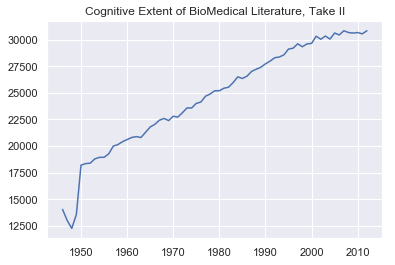

In [107]:
plt.plot(year10k.index,year10k.values,label='10k Quota')
#plt.plot(year10kb.index,year10kb.values)
#plt.plot(gbyc)
plt.title("Cognitive Extent of BioMedical Literature, Take II")
plt.savefig("Replication of Figure 2, take II", dpi=300)

In [100]:
df.head()

,pmid,year,number_authors,Phrases
0,12255545,1946,1,nutrition|expectant|nursing mother|relation|maternal|infant mortality|morbidity
1,12278355,1946,1,among primitive people
2,12305597,1946,1,vitaminc test|ovulation
3,12332284,1946,1,clinical use|oral basal temperature
4,16016713,1946,1,army medical library|retrospect|future


In [ ]:
# for figure 7, the paper says it uses the most recent time period.
# instead of grouping by year, we group by # of authors. 

In [101]:
mostrecenttimeperiod = df[df['year']==2012]

In [141]:
mostrecenttimeperiod

,year,number_authors,index,Phrases
13209262,2012,4,13209262,agroeconomic evaluation|projecta modeling approach
13209263,2012,9,13209263,renoprotective effect|telmisartan|renal injury|obese zucker rat
13209264,2012,4,13209264,amongst taiwanese outpatient|cancer
13209265,2012,2,13209265,screening|depression|emergency department patient
13209266,2012,3,13209266,malpractice claim|emergency physician|time|money
13209267,2012,5,13209267,superovulation|ofsh|norgestometgnrhcontrolled release|lh surge|hormone concentration|yield|oocyte|embryo|specific developmental stage
13209268,2012,8,13209268,department security program|community crime|employee assault
13209269,2012,5,13209269,interbreed embryo transfer|lamb growing performance|survival
13209270,2012,4,13209270,glycomolecule modification|seminiferous epithelial cell|acrosome|posttesticular spermatozoon|alpaca
13209271,2012,2,13209271,instability|stove antigen retrieval|immunohistochemistry


In [102]:
groupedbyteam = mostrecenttimeperiod[['Phrases','number_authors']].groupby('number_authors')

In [103]:
team_cog_ext = groupedbyteam.apply(lambda x: len(x.sample(1000,replace=True)['Phrases'].str.split("|",expand=True).stack().value_counts()))


In [104]:
top100 = team_cog_ext[0:100] #gets top 100 team sizes

In [105]:
top100.to_csv("DataForSecondFigure_CogExt_By_Team_For_most_Recent_year_take_II.csv")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


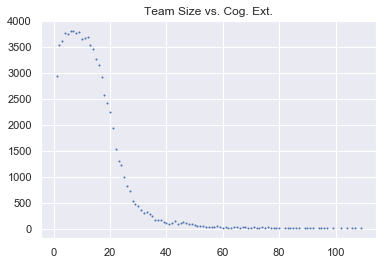

In [108]:
plt.scatter(top100.index,top100.values,s=1)
plt.title("Team Size vs. Cog. Ext.")
plt.savefig("TeamSizevsCogExtBioMedTakeII", dpi=300)

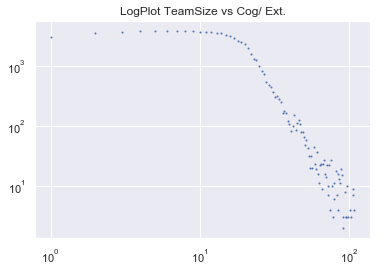

In [109]:
plt.yscale('log')
plt.xscale('log')
plt.scatter(top100.index,top100.values,s=1)
plt.title("LogPlot TeamSize vs Cog/ Ext.")
plt.savefig("LOGTeamSizevsCogExtBioMedTakeII",dpi=300)